# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

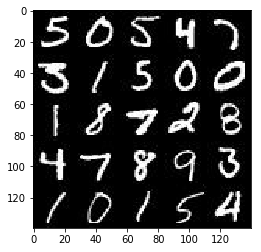

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

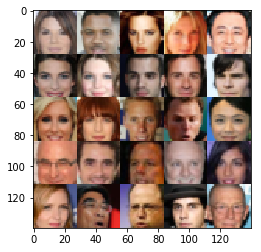

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.nn.dropout(layer1, 0.8)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.nn.dropout(layer2, 0.8)
        layer2 = tf.maximum(alpha * layer2, layer2)

        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.nn.dropout(layer3, 0.8)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        flat = tf.nn.dropout(flat, 0.5)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 2*2*256)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='valid',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real * 0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                batch_images = batch_images * 2
                z_batch = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: z_batch, input_real: batch_images, learn_rate: learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: z_batch, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2418... Generator Loss: 3.3605
Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 2.2459
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 3.7434
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 5.8369
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 1.7653
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 3.0699
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 5.4105
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 7.1515
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.5378


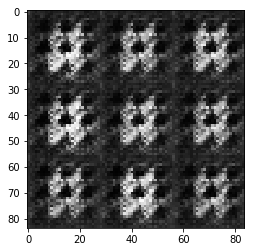

Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.4353
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 1.8881
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 2.6123
Epoch 1/2... Discriminator Loss: 0.3199... Generator Loss: 2.8310
Epoch 1/2... Discriminator Loss: 2.0050... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.4304
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 1.4562
Epoch 1/2... Discriminator Loss: 1.9090... Generator Loss: 0.3233


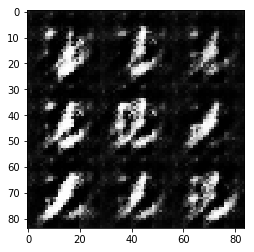

Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 2.2004
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 2.5758
Epoch 1/2... Discriminator Loss: 1.7224... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 3.0741
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.3435
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 3.7686
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.8093
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 3.2149


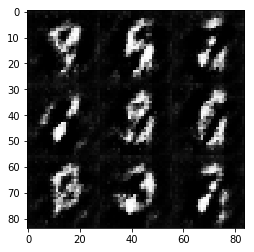

Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 1.2849
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 1.2198
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 2.2102
Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 3.8002
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.3034
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 2.1250
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 2.0762
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 1.2129


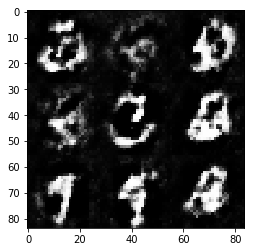

Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.7672
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 3.0791
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 2.0697
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.2499
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 1.5518
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 2.1418
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.8637


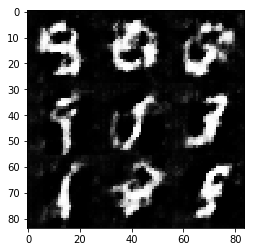

Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.5847
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 1.5528
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4164
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.4499


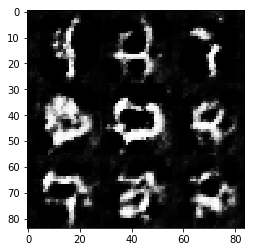

Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 1.2281
Epoch 1/2... Discriminator Loss: 1.8779... Generator Loss: 0.4494
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.6879


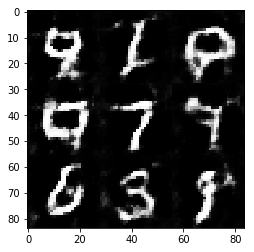

Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.5086
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 1.7528
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.5464
Epoch 1/2... Discriminator Loss: 1.5726... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.4462
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 1.4660
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.0115


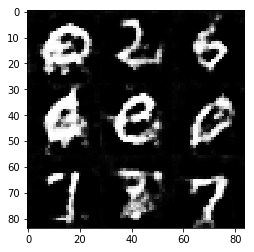

Epoch 1/2... Discriminator Loss: 2.2313... Generator Loss: 0.2362
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 1.3845
Epoch 1/2... Discriminator Loss: 1.6829... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.5300
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 0.8130


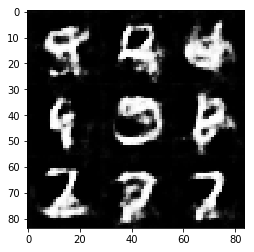

Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 2.7657
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.6703... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.5359
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 1.4870
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 1.5330
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 1.7732
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.7200


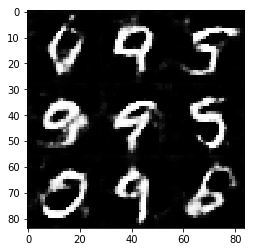

Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 0.9198... Generator Loss: 1.5096
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 1.9217
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 1.2650
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 1.4828
Epoch 1/2... Discriminator Loss: 1.6700... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 1.1677
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 1.6083


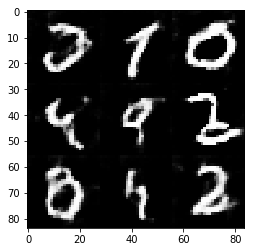

Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 1.7395... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.5237
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.4883


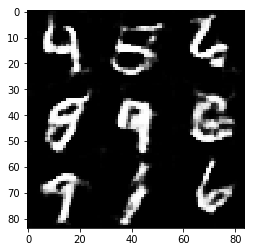

Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.5920
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.2006
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.7254


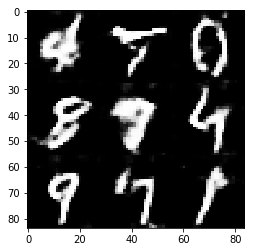

Epoch 1/2... Discriminator Loss: 1.6497... Generator Loss: 0.4203
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 1.5535
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 1.2817
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.6061


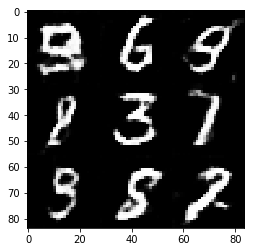

Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.1170
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 1.7305
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.4303


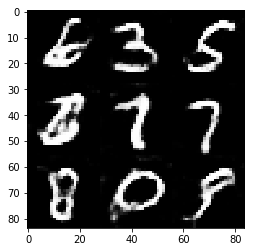

Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 2.0222
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.5813


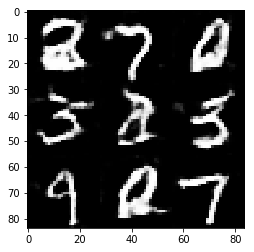

Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.3831
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.4451
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.6401
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.0868


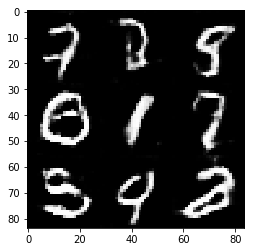

Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 1.3365
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 1.2534
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 1.9886
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 0.7157


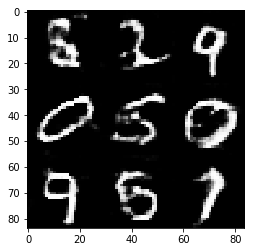

Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 1.6174
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.3570


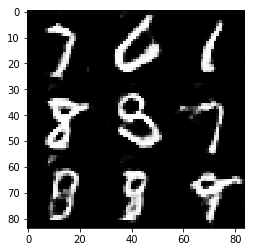

Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 1.3677
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 1.9193... Generator Loss: 0.3623
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.5237... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 1.1888
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 1.9584
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.6173


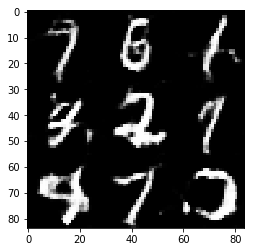

Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 1.4105
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.2698
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.9168


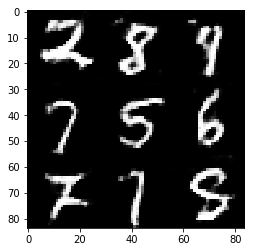

Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 1.1497


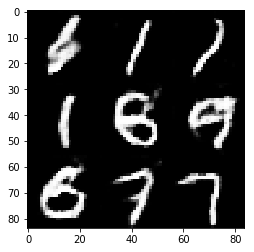

Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 1.0531
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 1.7325
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 1.8767
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.6052


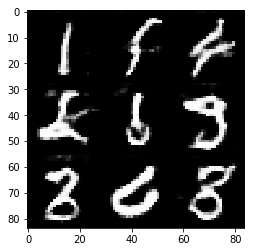

Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 1.6359
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.6401
Epoch 2/2... Discriminator Loss: 1.6705... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 1.1308


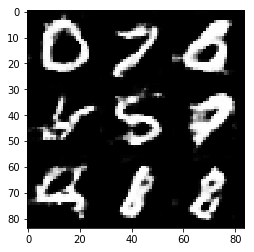

Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 1.1787
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.4814
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.6932
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 1.6530
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.5750


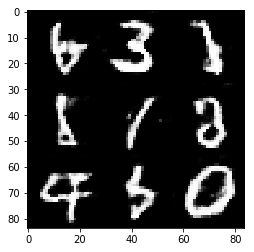

Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 1.9550
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.3584
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 1.7325
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 1.1420


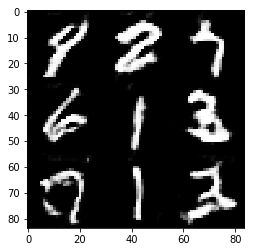

Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 1.9381
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.2413
Epoch 2/2... Discriminator Loss: 1.9439... Generator Loss: 0.4061
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.4132
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.6561
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.0780


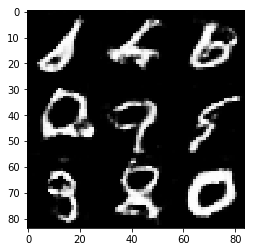

Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 1.9128
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.6708
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.2498


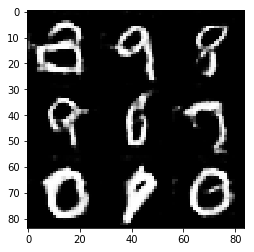

Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 1.7494
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.3987
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 1.5409
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.4166
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 1.4962


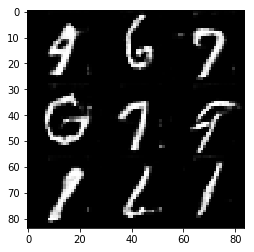

Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.2475
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 1.5963
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 1.5462
Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.4790
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 1.2361


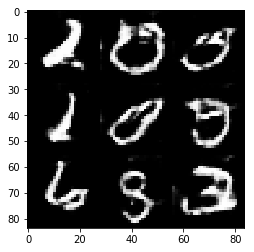

Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 0.9660... Generator Loss: 1.7751
Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 1.3947
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.5429
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 1.7652... Generator Loss: 0.4139
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.9451


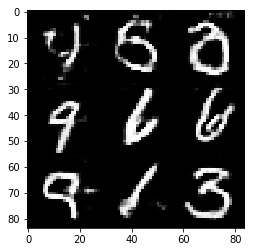

Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 1.7492
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.6124
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.2558
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.8758
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.2420
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.1111... Generator Loss: 1.3102


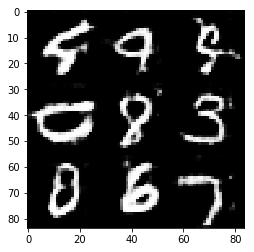

Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.9808
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.6105
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 2.5528
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.7305


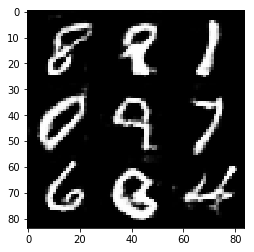

Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 1.5854
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.3119
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.9320
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.8382
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 2.0177
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 1.4363


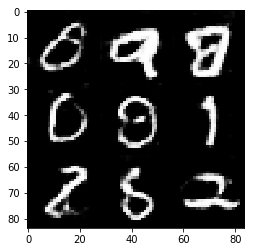

Epoch 2/2... Discriminator Loss: 1.5746... Generator Loss: 0.4385
Epoch 2/2... Discriminator Loss: 1.5313... Generator Loss: 0.7209
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.5978
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.4734
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.3596
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.0684


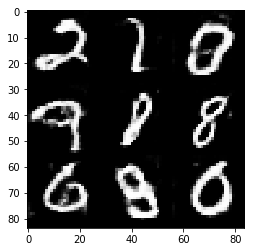

Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 1.6140
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 1.2572


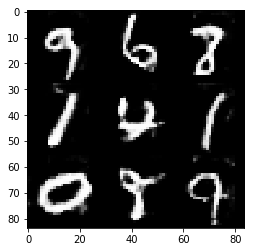

Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.8722
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.5829
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.0432
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.6887


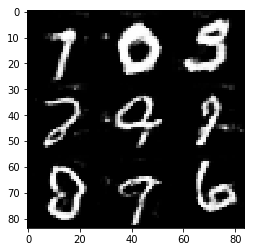

Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 1.7585
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 0.9755
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.4037


In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7058... Generator Loss: 10.2575
Epoch 1/1... Discriminator Loss: 2.3041... Generator Loss: 6.3813
Epoch 1/1... Discriminator Loss: 9.2253... Generator Loss: 0.0004
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 2.4193... Generator Loss: 0.2219
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 1.9158... Generator Loss: 0.2224


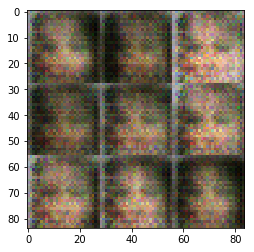

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.9507
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 1.8211... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5650


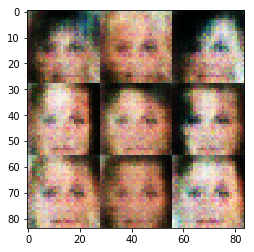

Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 2.0591... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 2.3850... Generator Loss: 0.2073
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.1709


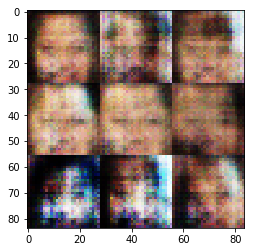

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.7707... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.8517... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9103


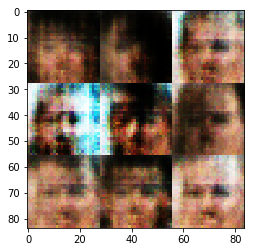

Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 0.3173
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.5946


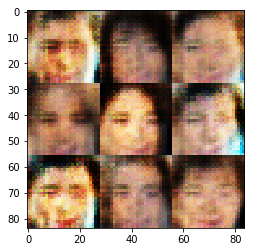

Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.3292
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.0861


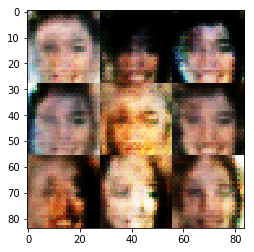

Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 2.0907
Epoch 1/1... Discriminator Loss: 1.8941... Generator Loss: 2.5229


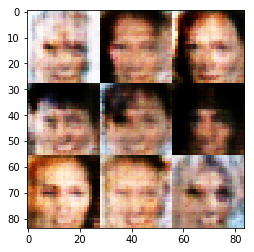

Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 2.1254
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 2.6894
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 2.4461... Generator Loss: 2.3455


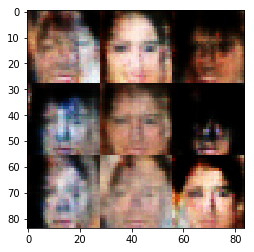

Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 2.0352... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 1.9751
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.4735


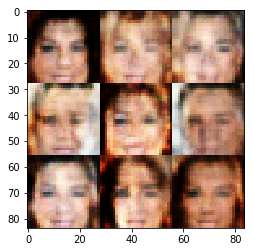

Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 1.7736
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 2.5423
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7344


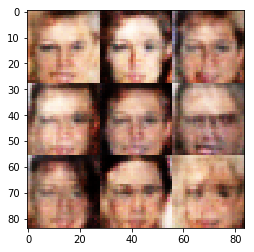

Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.7844... Generator Loss: 0.2600
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4638


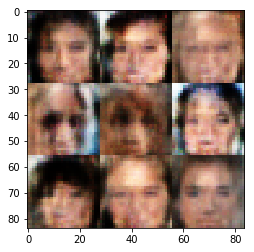

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 1.4285
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 1.9395
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4876


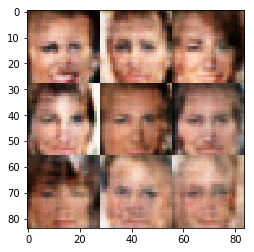

Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6228


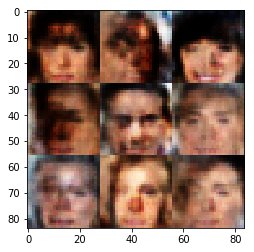

Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.3831


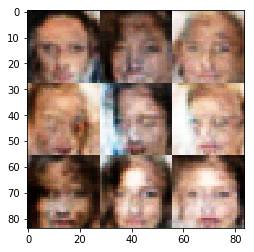

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 2.0517... Generator Loss: 0.2064
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.3395
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.5121


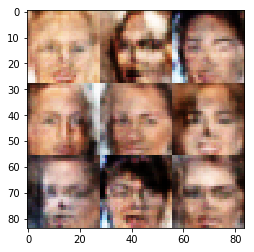

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5392


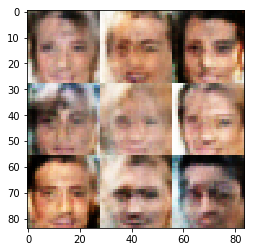

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.2684


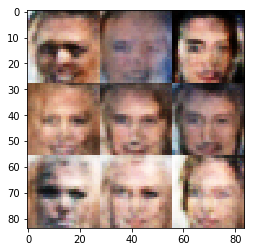

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7530


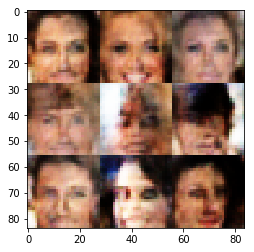

Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.3332
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7085


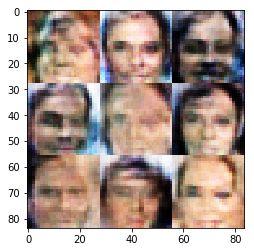

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.4326


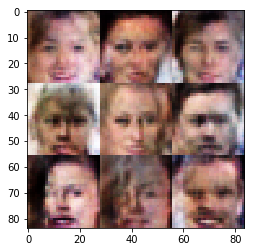

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.2369
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5699


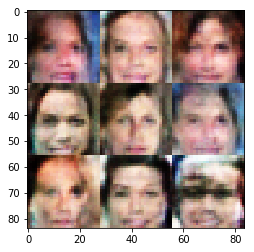

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.3258
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.5121


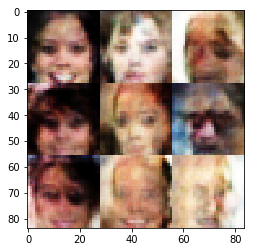

Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.3335


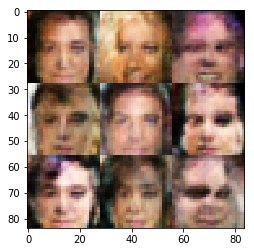

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.3916


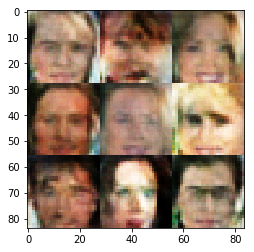

Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.5830


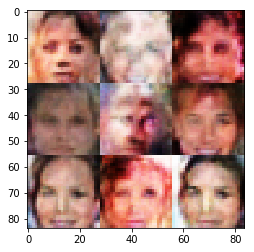

Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7222


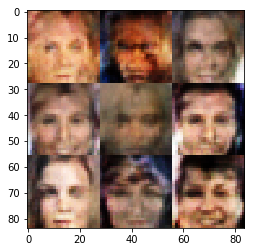

Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.3780
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6345


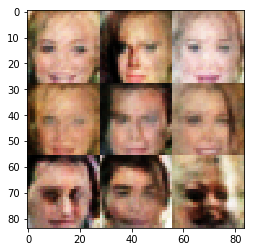

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7090


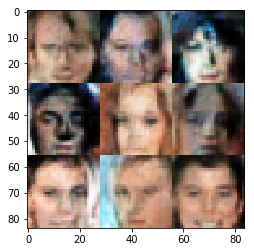

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.1884


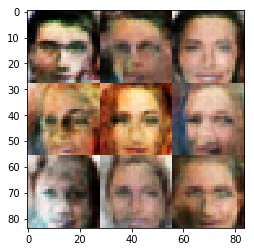

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.1060


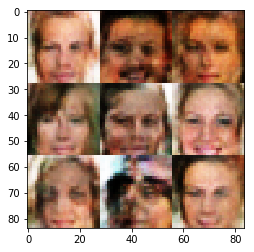

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.6711


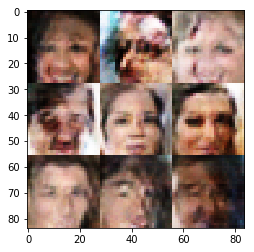

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.3129


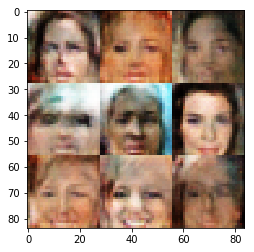

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.5737


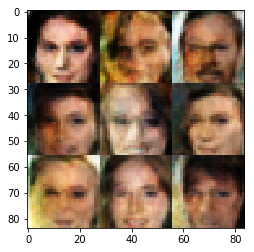

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.8699... Generator Loss: 0.2111
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8341


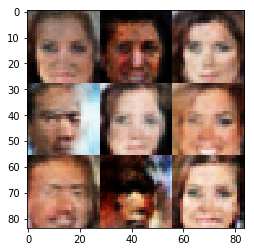

Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6846


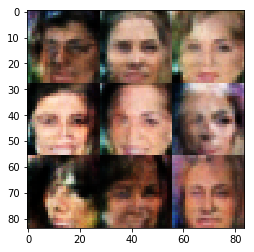

Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.6689


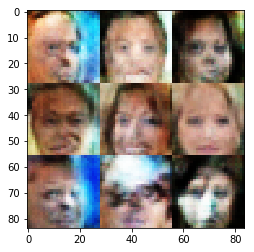

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6650


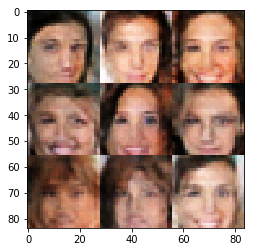

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.5809


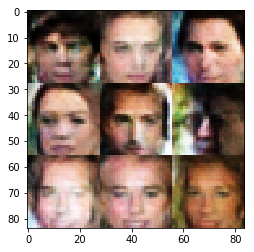

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6148


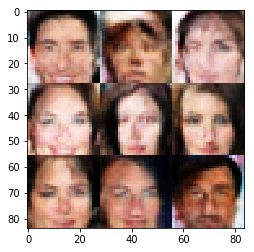

Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.8671


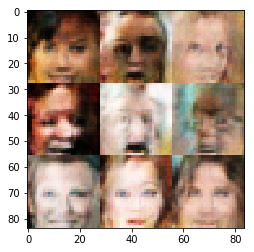

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.8700... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5734


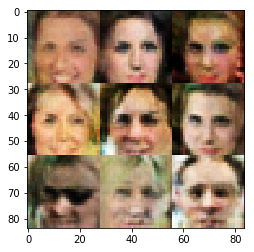

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.6969


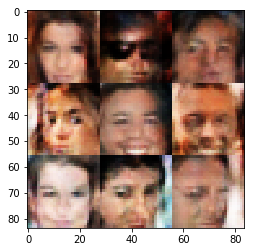

Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.9369


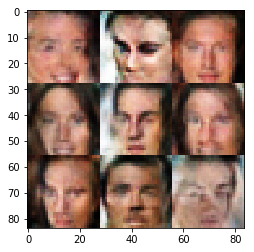

Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.6334... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.7529


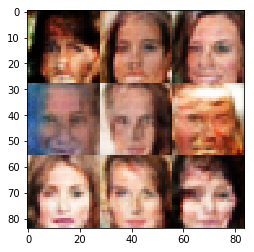

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.9609


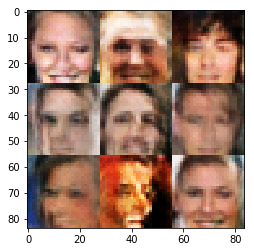

Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8022


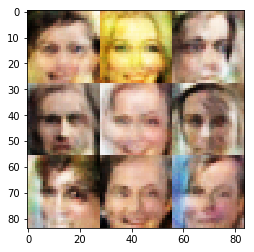

Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8281


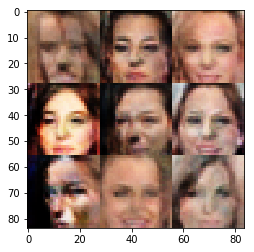

Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9885


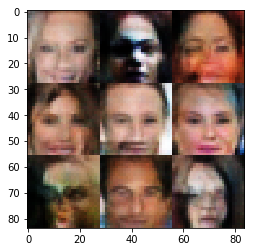

Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.4929


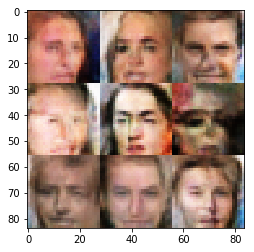

Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6159


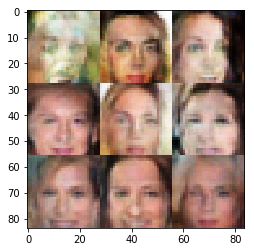

Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9017


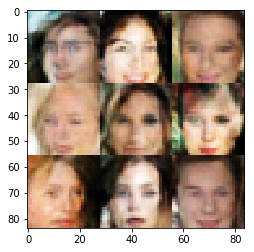

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.0945


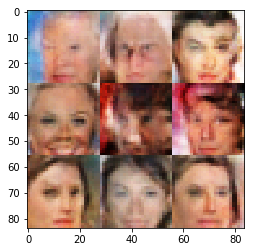

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.0112


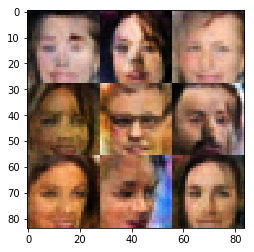

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6763


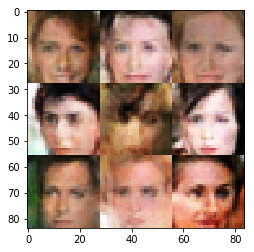

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7372


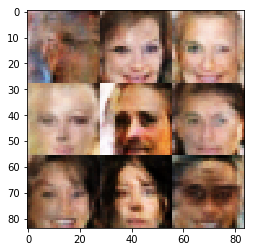

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9999


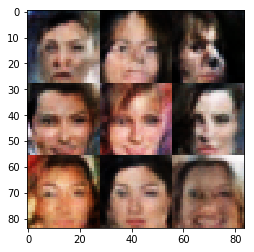

Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8402


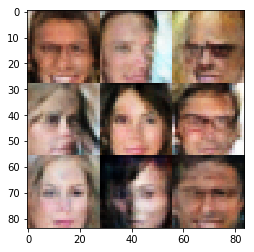

Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9280


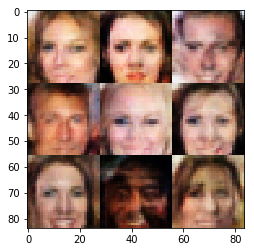

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.0603


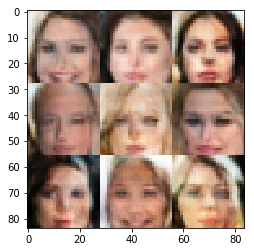

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 1.7367


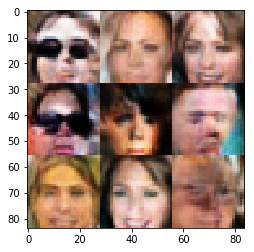

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0143


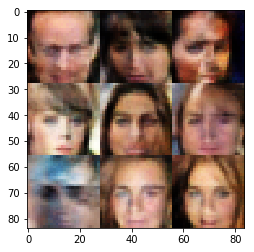

Epoch 1/1... Discriminator Loss: 1.7489... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 1.7275
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.0068


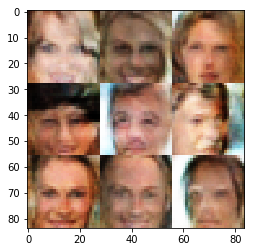

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5267


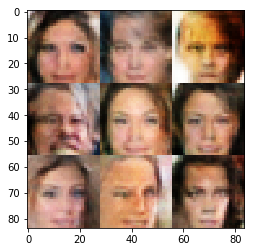

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7869


In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.